### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from pathlib import Path
from mne.io import read_info
from hmpai.data import StageFinder, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
from hmpai.ica import ICA

### Short version using StageFinder

In [2]:
info_path = Path("../data/sat1/preprocessed/processed_0001_epo.fif")
positions = read_info(info_path)

%load_ext memory_profiler

In [3]:
# Amount of cores to use in multiprocessing
cpus = 12

epoched_data_path = Path("../data/sat1/data_100hz.nc")
output_path = Path("../data/sat1/stage_data_100hz.nc")
conditions = ["AC", "SP"]
labels = {"AC": SAT1_STAGES_ACCURACY, "SP": SAT1_STAGES_SPEED}

stage_finder = StageFinder(
    epoched_data_path,
    labels,
    conditions=conditions,
    cpus=cpus,
    fit_function="fit_single",  # n_events is extracted from the amount of labels in 'conditions' variable
    fit_args={"starting_points": 100},
    verbose=False,
)

# Use fit(), letting the model decide on an amount of events
# stage_data = add_stages_to_dataset(
#     epoched_data_path, output_path, labels, conditions=conditions, cpus=cpus
# )

Transforming epoched data to principal component (PC) space


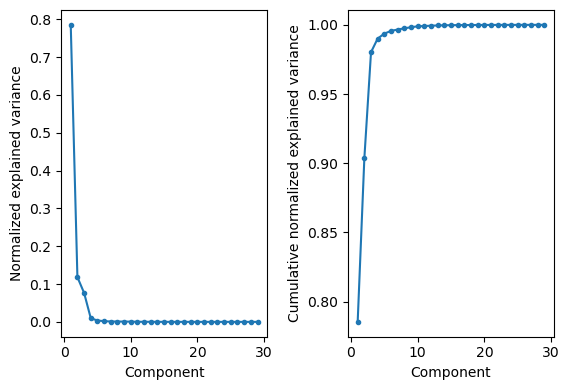

Fitting HMP model for AC condition
Estimating 4 events model with 100 starting point(s)


  0%|          | 0/100 [00:00<?, ?it/s]

parameters estimated for 4 events model
Fitting HMP model for SP condition
Estimating 3 events model with 100 starting point(s)


  0%|          | 0/100 [00:00<?, ?it/s]

parameters estimated for 3 events model



Filename: /mnt/c/git/hmp/src/hsmm_mvpy/models.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   197   2165.0 MiB    742.9 MiB           2       def fit_single(self, n_events=None, magnitudes=None, parameters=None, parameters_to_fix=None, 
   198                                                            magnitudes_to_fix=None, tolerance=1e-4, max_iteration=1e3, maximization=True, min_iteration = 1,
   199                                                            starting_points=1, method='random', return_max=True, verbose=True, cpus=None):
   200                                                 '''
   201                                                 Fit HMP for a single n_events model
   202                                                 
   203                                                 parameters
   204                                                 ----------
   205                                                 n_events : int
   206                    

In [4]:
%mprun -f hmp.models.hmp.fit_single stage_finder.fit_model()

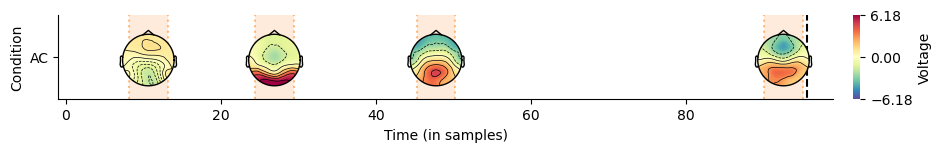

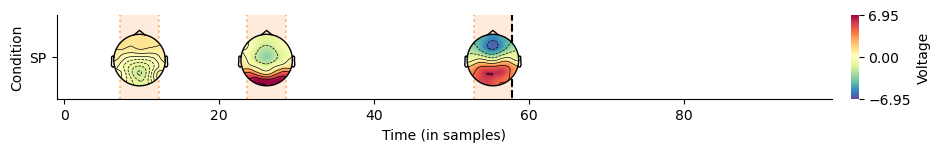

In [4]:
# Visualize model to check if fitting was done as expected

stage_finder.visualize_model(positions)

In [5]:
# Add labels to dataset
stage_data = stage_finder.label_model()

Labeling dataset for AC condition
Processing participant 0001
Processing participant 0002
Processing participant 0003
Processing participant 0004
Processing participant 0005
Processing participant 0006
Processing participant 0007
Processing participant 0008
Processing participant 0009
Processing participant 0010
Processing participant 0011
Processing participant 0012
Processing participant 0013
Processing participant 0014
Processing participant 0015
Processing participant 0016
Processing participant 0017
Processing participant 0018
Processing participant 0019
Processing participant 0020
Processing participant 0021
Processing participant 0022
Processing participant 0023
Processing participant 0024
Processing participant 0025
Labeling dataset for SP condition
Processing participant 0001
Processing participant 0002
Processing participant 0003
Processing participant 0004
Processing participant 0005
Processing participant 0006
Processing participant 0007
Processing participant 0008
Processi

In [6]:
# Save labelled dataset
stage_data.to_netcdf(output_path)

In [7]:
stage_data.sel(participant="0021", epochs=1).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'response', 'response', 'response', 'response', 'response',
       'response', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', ''], dtype=object)
Coordinates:
    epochs       int64 1
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 1.0
    resp         object 'resp_right'
    RT           float64 1.388e+03
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'

#### Calculate ICA components

In [21]:
output_path = Path("../data/sat1/stage_data_100hz_ica.nc")

In [45]:
stage_data = xr.load_dataset(Path("../data/sat1/stage_data_100hz.nc"))

In [46]:
ica = ICA(stage_data, info_path=info_path)

In [47]:
stage_data_new = ica.reorder_dataset(stage_data)

Reordering dataset
Participant: 0
Creating RawArray with float64 data, n_channels=30, n_times=14498
    Range : 0 ... 14497 =      0.000 ...   144.970 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 0.5s.


/mnt/c/git/hmp-ai/pkg/hmpai/ica.py:119: RuntimeWarning: Mean of empty slice
  mean_comp = np.nanmean(components, axis=0)


Participant: 1
Creating RawArray with float64 data, n_channels=30, n_times=12325
    Range : 0 ... 12324 =      0.000 ...   123.240 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 1.5s.
Mean correlation:  0.6472988631470368
Participant: 2
Creating RawArray with float64 data, n_channels=30, n_times=13747
    Range : 0 ... 13746 =      0.000 ...   137.460 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 0.7s.
Mean correlation:  0.6653784271154507
Participant: 3
Creating RawArray with float64 data, n_channels=30, n_times=13255
    Range : 0 ... 13254 =      0.000 ...   132.540 secs
Ready.
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 0.7s.
Mean correlation:  0.6311846150152259
Participant: 4
Creating RawArray with

In [48]:
stage_data_new

<xarray.Dataset>
Dimensions:            (epochs: 200, channels: 30, samples: 199,
                        participant: 25, components1: 30, components2: 30)
Coordinates:
  * epochs             (epochs) int64 0 1 2 3 4 5 6 ... 194 195 196 197 198 199
  * channels           (channels) object 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples            (samples) int64 0 1 2 3 4 5 6 ... 193 194 195 196 197 198
    stim               (participant, epochs) float64 nan 1.0 1.0 ... 2.0 nan 2.0
    resp               (participant, epochs) object '' ... 'resp_left'
    rt                 (participant, epochs) float64 nan 0.683 ... nan 1.02
    cue                (participant, epochs) object '' 'SP' 'AC' ... '' 'AC'
    movement           (participant, epochs) object '' ... 'stim_right'
    trigger            (participant, epochs) object '' ... 'AC/stim_right/res...
  * participant        (participant) object '0001' '0002' ... '0024' '0025'
  * components1        (components1) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
  * components2        (components2) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
Data variables:
    data               (participant, epochs, components1, samples) float64 na...
    labels             (participant, epochs, samples) object '' '' '' ... '' ''
    unmixing_matrices  (participant, components1, components2) float64 0.1448...
    mixing_matrices    (participant, components1, components2) float64 1.744 ...
    components         (participant, components1, components2) float64 -0.213...
Attributes:
    sfreq:    100.0
    offset:   0

In [49]:
stage_data_new.to_netcdf(output_path)
# ica.save(output_path.with_suffix(".fif"))

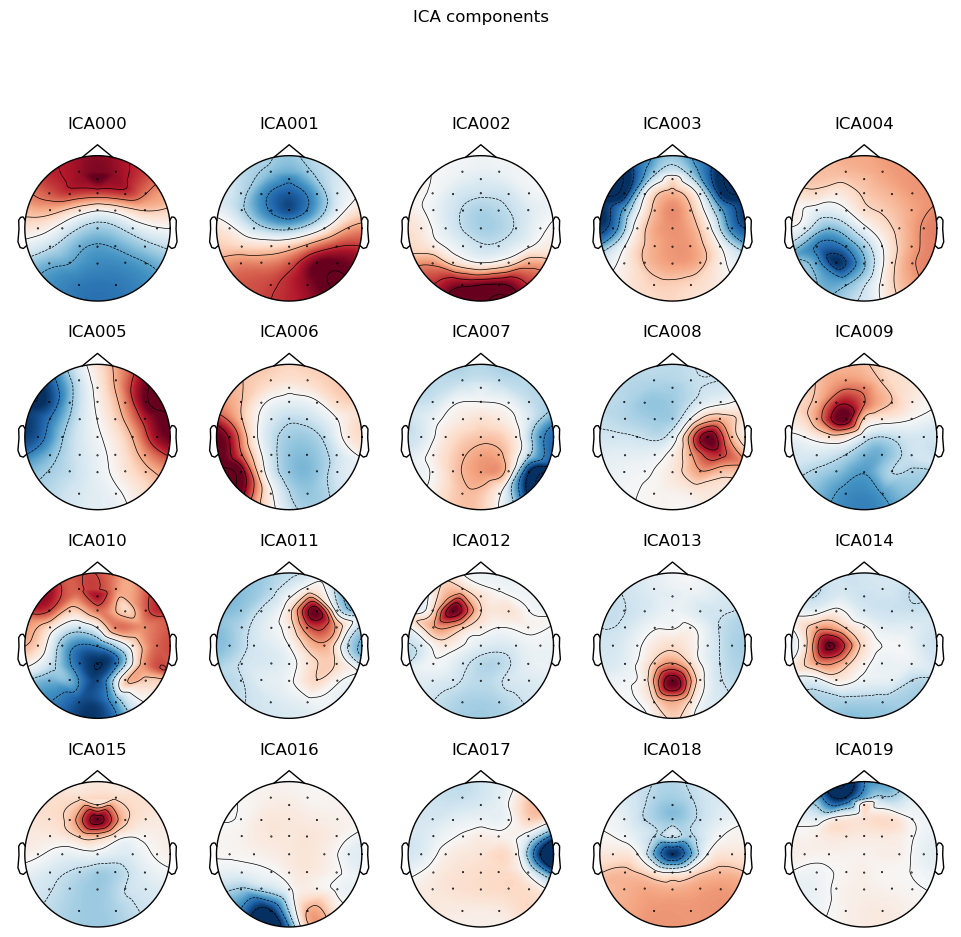

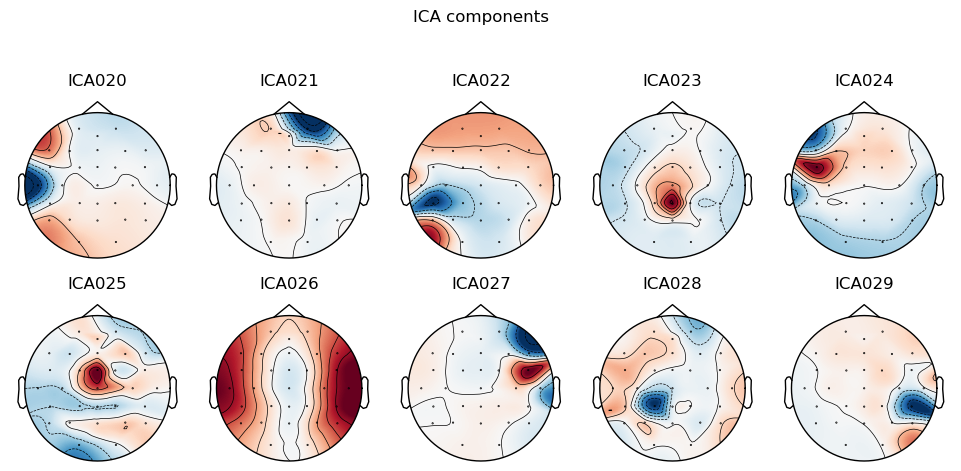

In [47]:
ica.plot_ica()

In [6]:
# Save labelled dataset
stage_data.to_netcdf(output_path)

In [7]:
# Save models
hmp.utils.save_fit(stage_finder.fits[0], "100hz_accuracy.nc")
hmp.utils.save_fit(stage_finder.fits[1], "100hz_speed.nc")

100hz_accuracy.nc saved
100hz_speed.nc saved


### Add stage information to unprocessed data files

In [1]:
import xarray as xr
from pathlib import Path
import numpy as np
from hmpai.data import add_stage_data_to_unprocessed

2023-10-22 13:06:33.960422: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-22 13:06:34.502274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_500hz = xr.load_dataset(Path("data/sat1/data_unprocessed_500hz.nc"))
output_path = Path("data/sat1/stage_data_unprocessed_500hz")

stage_data_500hz = add_stage_data_to_unprocessed(
    Path("data/sat1/stage_data.nc"), data_500hz
)

In [4]:
stage_data_500hz.to_netcdf(output_path)

In [5]:
data_100hz = xr.load_dataset(Path("data/sat1/data_unprocessed_100hz.nc"))
output_path = Path("data/sat1/stage_data_unprocessed_100hz")

stage_data_100hz = add_stage_data_to_unprocessed(
    Path("data/sat1/stage_data.nc"), data_100hz
)

In [6]:
stage_data_100hz.to_netcdf(output_path)

### Deprecated/testing

In [ ]:
stage_data.sel(participant="0001", epochs=1).labels

<xarray.DataArray 'labels' (samples: 199)>
array(['pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'pre-attentive', 'pre-attentive', 'pre-attentive',
       'pre-attentive', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'response', 'response',
       'response', 'response', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
       '', ''], dtype=object)
Coordinates:
    epochs       int64 1
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         float64 1.0
    resp         object 'resp_left'
    rt           float64 0.683
    cue          object 'SP'
    movement     object 'stim_left'
    trigger      object 'SP/stim_left/resp_left'
    participant  <U4 '0001'

### Manual version

In [ ]:
# Amount of cores to use in multiprocessing
cpus = 12

# Load complete SAT1 dataset
eeg_data = xr.load_dataset("data/sat1/data.nc")

# Load x and y positions of electrodes
positions_path = Path("data/sat1/preprocessed/processed_0001_epo.fif")
positions = read_info(Path("data/sat1/preprocessed/processed_0001_epo.fif"))

output_path = Path("data/sat1/stage_data.nc")

In [ ]:
eeg_data

<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 199, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
    stim         (participant, epochs) float64 2.0 1.0 1.0 1.0 ... 2.0 1.0 1.0
    resp         (participant, epochs) object 'resp_right' ... 'resp_left'
    rt           (participant, epochs) float64 1.388 1.388 0.47 ... 0.317 0.756
    cue          (participant, epochs) object 'AC' 'AC' 'SP' ... 'AC' 'SP' 'AC'
    movement     (participant, epochs) object 'stim_right' ... 'stim_left'
    trigger      (participant, epochs) object 'AC/stim_right/resp_right' ... ...
  * participant  (participant) object '0021' '0022' '0023' '0024'
Data variables:
    data         (participant, epochs, channels, samples) float64 -1.449 ... nan
Attributes:
    sfreq:    100.0
    offset:   0

In [ ]:
# Transform data into principal component (PC) space
# will ask in a pop-up how many components to keep
# selection depends on data size, choose number at cutoff (90/99%) or at 'elbow' point
hmp_data = hmp.utils.transform_data(eeg_data, n_comp=4)

### Initialize models

Number of potential magnitudes: 81
Because of decimation 27 will be estimated.


100%|██████████| 27/27 [02:54<00:00,  6.48s/it]


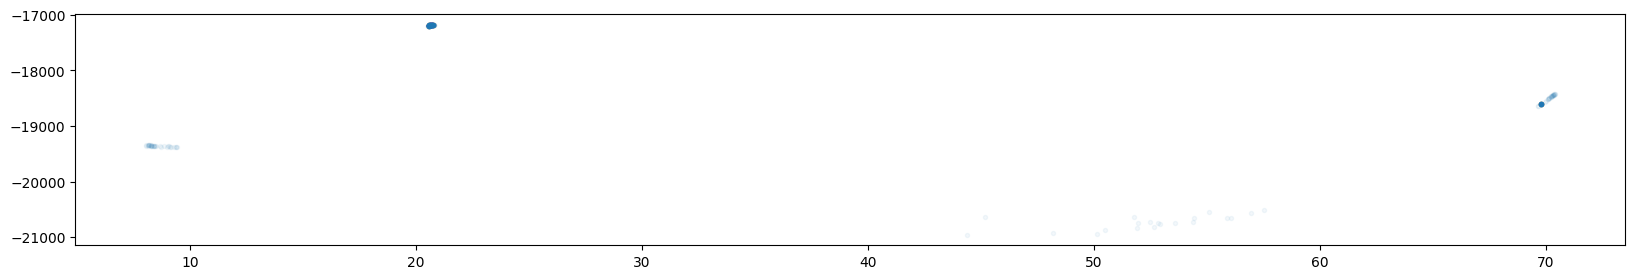

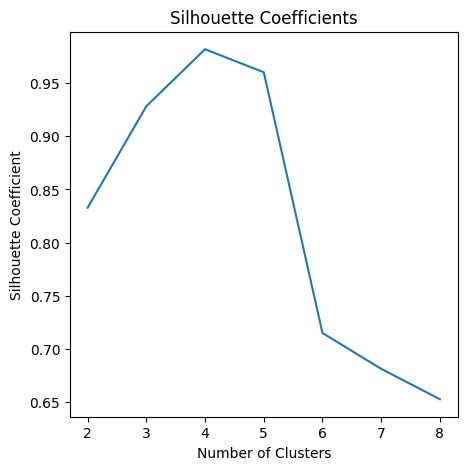

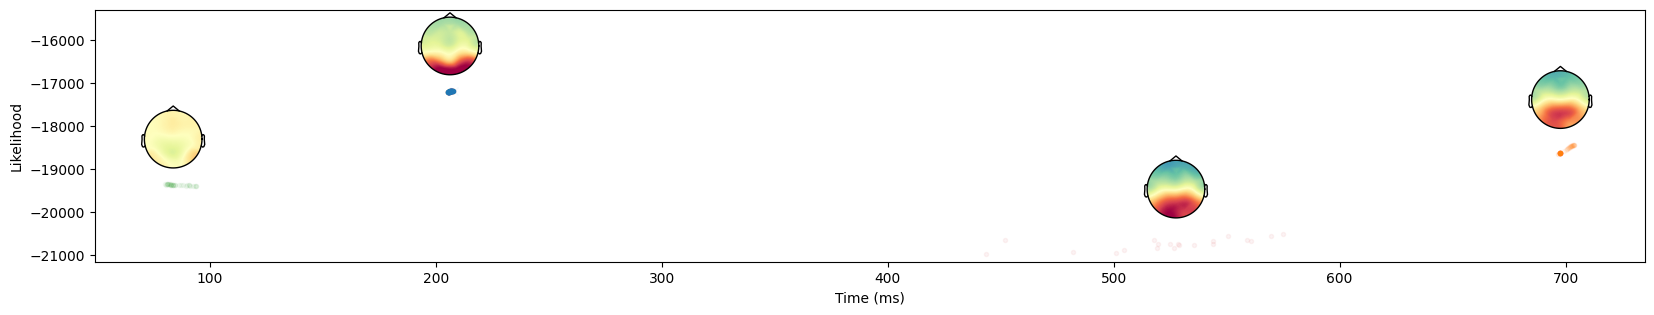

Estimating 4 events model
Parameters estimated for 4 events model


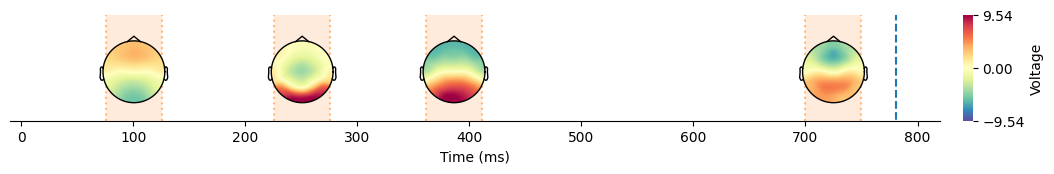

In [ ]:
# Alternative method of fitting without supplying nr of events, use to explore new datasets
subset = eeg_data.where(eeg_data["cue"].str.contains("AC"))

init_accuracy = hmp.models.hmp(
    hmp_data,
    subset,
    cpus=cpus,
    sfreq=eeg_data.sfreq,
    estimate_magnitudes=True,
)
# calc estimates
lkhs, mags, channels, times = init_accuracy.sliding_event_mags(
    subset, step=5, decimate_grid=3, cpu=cpus, plot=True, min_iteration=10
)

# cluster in time, lkh, and mags
mags_cl, pars_cl = hmp.clusters.cluster_events(
    init_accuracy,
    lkhs,
    mags,
    channels,
    times,
    method="time_x_lkh_x_mags",
    max_clust=8,
    p_outlier=0.05,
    info=positions,
    calc_outliers=True,
)

# fit final model
best_estimate = init_accuracy.fit_single(
    mags_cl.shape[0], magnitudes=mags_cl, parameters=pars_cl
)
hmp.visu.plot_topo_timecourse(
    eeg_data,
    best_estimate,
    positions,
    init_accuracy,
    magnify=1,
    sensors=False,
    time_step=1000 / init_accuracy.sfreq,
    xlabel="Time (ms)",
    contours=0,
    event_lines=True,
    colorbar=True,
)

In [ ]:
hmp_accuracy_data = hmp.utils.condition_selection(
    hmp_data, eeg_data, "AC", variable="cue"
)
model_accuracy = hmp.models.hmp(hmp_accuracy_data, cpus=cpus, sfreq=eeg_data.sfreq)


hmp_speed_data = hmp.utils.condition_selection(hmp_data, eeg_data, "SP", variable="cue")
model_speed = hmp.models.hmp(hmp_speed_data, cpus=cpus, sfreq=eeg_data.sfreq)

#### Regular fitting

In [ ]:
accuracy_epoch = eeg_data.where(eeg_data["cue"].str.contains("AC"), drop=True)
bootstrapped = hmp.resample.bootstrapping(
    data=accuracy_epoch,
    dim=["epochs", "participant"],
    n_iterations=10,
    init=model_accuracy,
    positions=positions,
    sfreq=eeg_data.sfreq,
    cpus=cpus,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
fit_accuracy = model_accuracy.fit_single_conds()

AssertionError: fit_single_conds() requires a magnitude and/or parameter map

In [ ]:
# Let model find stage transitions
# fit_accuracy = model_accuracy.fit(grid_points=10, fix_iter=False)
fit_accuracy = model_accuracy.fit()

  0%|          | 0/91 [00:00<?, ?it/s]

Transition event 1 found around sample 10
Transition event 2 found around sample 28
Transition event 3 found around sample 56
Transition event 4 found around sample 87
Estimating 4 events model
parameters estimated for 4 events model


In [ ]:
fit_speed = model_speed.fit()

  0%|          | 0/52 [00:00<?, ?it/s]

Transition event 1 found around sample 24
Transition event 2 found around sample 47
Estimating 2 events model
parameters estimated for 2 events model


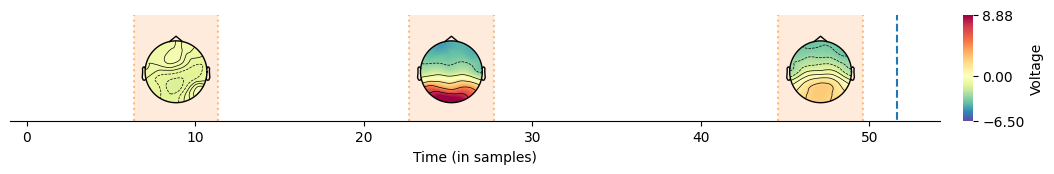

In [ ]:
hmp.visu.plot_topo_timecourse(
    eeg_data,
    fit_speed,
    positions,
    model_speed,
    vmin=-6.5,
    times_to_display=np.mean(model_speed.ends - model_speed.starts),
)

In [ ]:
# Tell model amount of events
fit_accuracy = model_accuracy.fit_single(4, starting_points=1000)
fit_speed = model_speed.fit_single(3, starting_points=1000)

Estimating 4 events model with 1000 starting point(s)


  0%|          | 0/1000 [00:00<?, ?it/s]

parameters estimated for 4 events model
Estimating 3 events model with 1000 starting point(s)


  0%|          | 0/1000 [00:00<?, ?it/s]

parameters estimated for 3 events model


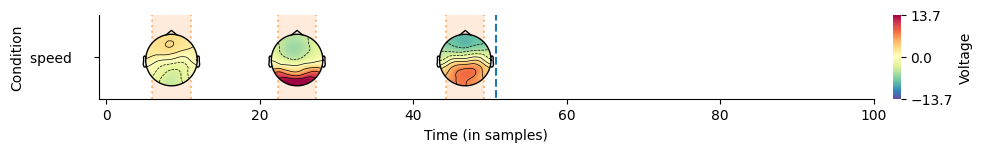

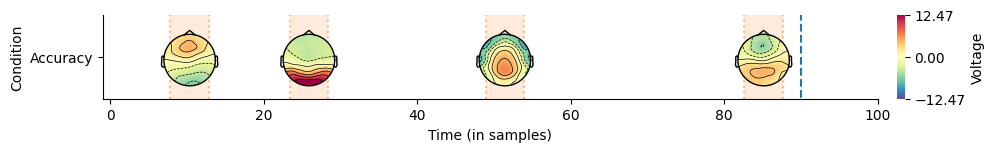

In [ ]:
for condition in zip(
    [fit_speed, fit_accuracy],
    [model_speed, model_accuracy],
    [hmp_speed_data, hmp_accuracy_data],
    ["speed    ", "Accuracy"],
):
    hmp.visu.plot_topo_timecourse(
        eeg_data,
        condition[0],
        positions,
        condition[1],
        times_to_display=np.mean(condition[1].ends - condition[1].starts),
        max_time=100,
        figsize=(10, 1),
        ylabels={"Condition": [condition[3]]},
    )

In [ ]:
condition_times = []
for cond in zip(
    [model_speed, model_accuracy], [fit_speed, fit_accuracy]
):  # Not very neat, to replace later
    condition_times.append(
        cond[0].compute_times(
            cond[0], cond[1].dropna("event"), fill_value=0, add_rt=True
        )
    )
condition_times = np.array(condition_times, dtype=object)

<Axes: xlabel='Cumulative stage durations from stimulus onset (ms)'>

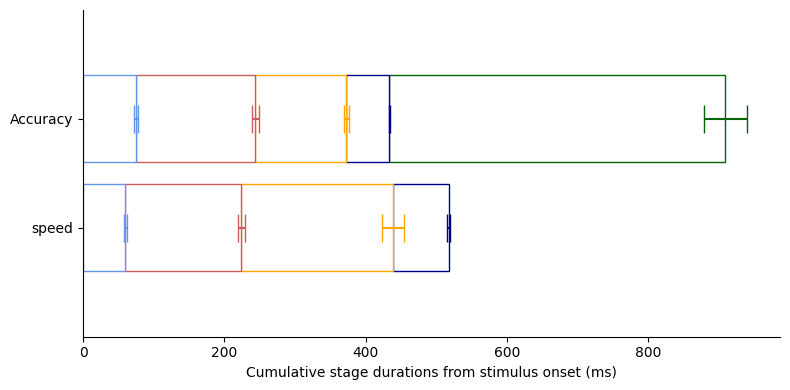

In [ ]:
hmp.visu.plot_latencies_average(
    condition_times,
    time_step=1000 / model_speed.sfreq,
    labels=["speed", "Accuracy"],
    errs="ci",
)

In [ ]:
fit_accuracy.eventprobs.idxmax(dim="samples").diff("event").mean(
    dim="trial_x_participant"
)
# .diff('event').mean(dim='trial_x_participant')

<xarray.DataArray 'samples' (event: 3)>
array([16.43250689, 23.24517906, 37.33333333])
Coordinates:
  * event    (event) int64 1 2 3

In [ ]:
# Merge AC and SP condition labels (an epoch is either AC or SP so these are sets without common members)
merged = np.where(acc_labels == np.nan, sp_labels, acc_labels)
# Add stage info to eeg_data Dataset and save
stage_data = eeg_data.assign_coords(
    labels=(["participant", "epochs", "samples"], merged)
)
stage_data.to_netcdf(output_path)

# Debugging

In [ ]:
# Check dataset size in MB
print(eeg_data.nbytes / (1024**2))
print(stage_data.nbytes / (1024**2))

227.9697723388672
235.56101989746094


In [ ]:
stage_data.sel(participant="0021", epochs=1, samples=slice(1, 150)).labels

<xarray.DataArray 'labels' (samples: 150)>
array([nan, nan, nan, nan, 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'encoding', 'encoding', 'encoding',
       'encoding', 'encoding', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'decision',
       'decision', 'decision', 'decision', 'decision', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'confirmation', 'confirmation', 'confirmation',
       'confirmation', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan], dtype=object)
Coordinates:
    epochs       int64 1
  * samples      (samples) int64 1 2 3 4 5 6 7 8 ... 144 145 146 147 148 149 150
    stim         float64 1.0
    resp         object 'resp_right'
    rt           float64 1.388
    cue          object 'AC'
    movement     object 'stim_left'
    trigger      object 'AC/stim_left/resp_right'
    participant  <U4 '0021'
    labels       (samples) object nan nan nan nan 'encoding' ... nan nan nan nan

In [ ]:
int(eeg_data.sel(participant="0021", epochs=1).isnull().argmax("samples").data[0])

139

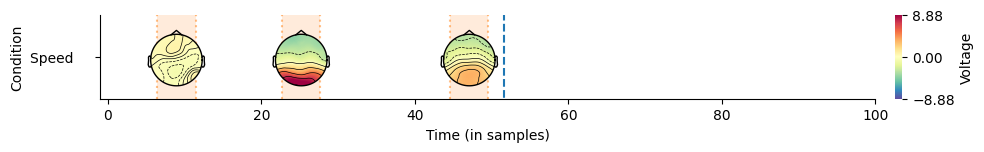

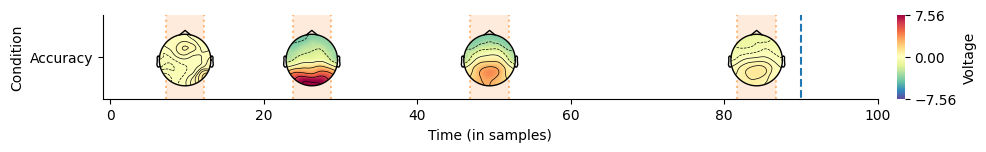

In [ ]:
for condition in zip(
    [fit_speed, fit_accuracy],
    [model_speed, model_accuracy],
    [hmp_speed_data, hmp_accuracy_data],
    ["Speed    ", "Accuracy"],
):
    hmp.visu.plot_topo_timecourse(
        eeg_data,
        condition[0],
        positions,
        condition[1],
        times_to_display=np.mean(condition[1].ends - condition[1].starts),
        max_time=100,
        figsize=(10, 1),
        ylabels={"Condition": [condition[3]]},
    )